In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('day.csv', index_col = [0])

## checking data

In [109]:
df.count().values

array([730, 730, 730, 730, 730, 730, 730, 730, 730, 730, 730, 730, 730,
       730, 730])

In [4]:
cat_vars = ['season','yr','mnth','holiday','weekday','workingday','weathersit']

## understading basic info in data - EDA

## target variables corelation with independent categorical variables

<Axes: title={'center': 'Bookings against weather situation'}, ylabel='Frequency'>

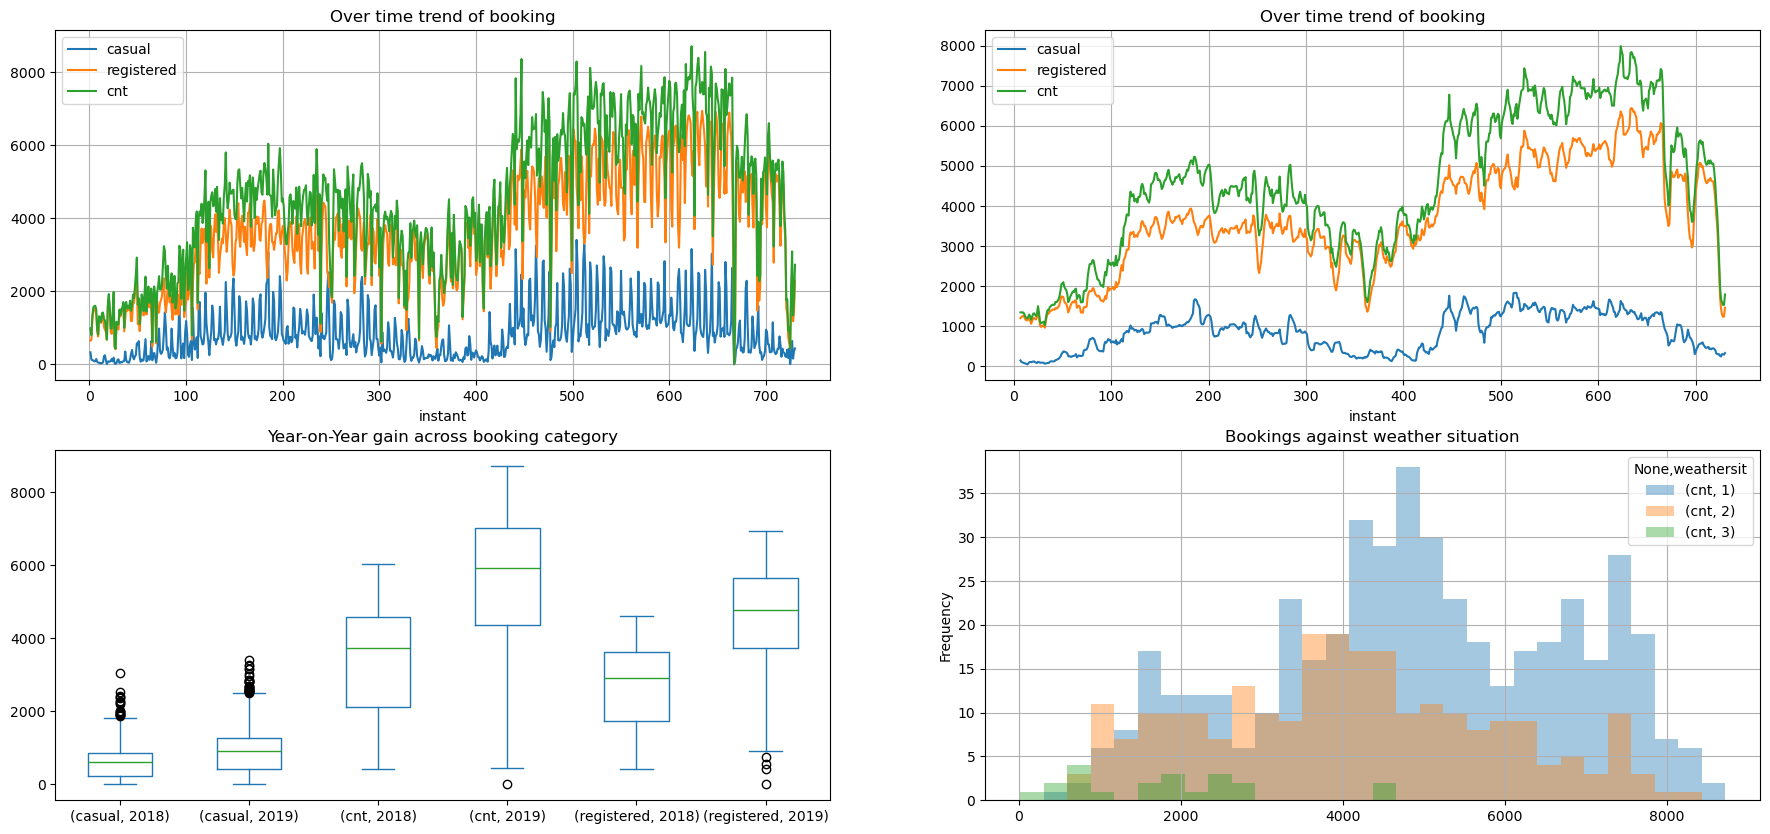

In [5]:
fig, axes = plt.subplots(2,2, figsize = (22,10))
df[['casual','registered','cnt']].plot( grid = True, title = 'Over time trend of booking', ax =axes[0,0] )

## getting rolling plot as fluctuation is because of weekday and weekend
df[['casual','registered','cnt']].rolling(7).mean().plot( grid = True, title = 'Over time trend of booking', ax =axes[0,1] )

## in second year, registered has increased but not casual, checking it in more detail
t_df = df.copy()
t_df['yr'] =  np.where(t_df.yr == 0, '2018', '2019')
t_df[['yr', 'casual','registered','cnt']].reset_index().pivot_table(index = 'instant', columns = 'yr', values = ['casual','registered','cnt']).\
plot(kind = 'box', title = 'Year-on-Year gain across booking category', ax = axes[1,0])

## checking impact with weather conditions
df[['cnt', 'weathersit']].reset_index().pivot_table(index = 'instant', columns = 'weathersit', values = ['cnt'])\
.plot(kind = 'hist', alpha = 0.4, bins = 30, grid = True, title = 'Bookings against weather situation', ax = axes[1,1])


## Take aways
1. Second year was much better than first, buy only for registered users, there was minimal or no change in casual bookings.
2. Hence we will need 2 models separately for 2 types and later sum these 2 answers to get final perfomance
3. Majority of daily level fluctuations in bookings are cleaned at weekly level, meaning weekday (working/not working give some small fluctuations in the booking)
4. Weather has a big impact,
5.     1: Clear, Few clouds, Partly cloudy, Partly cloudy  --- has max bookings
	   2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist -- relatively less bookings
	   3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds - almost to no bookings

In [6]:
cc =  ['season','yr', 'mnth','holiday','weekday','weathersit']

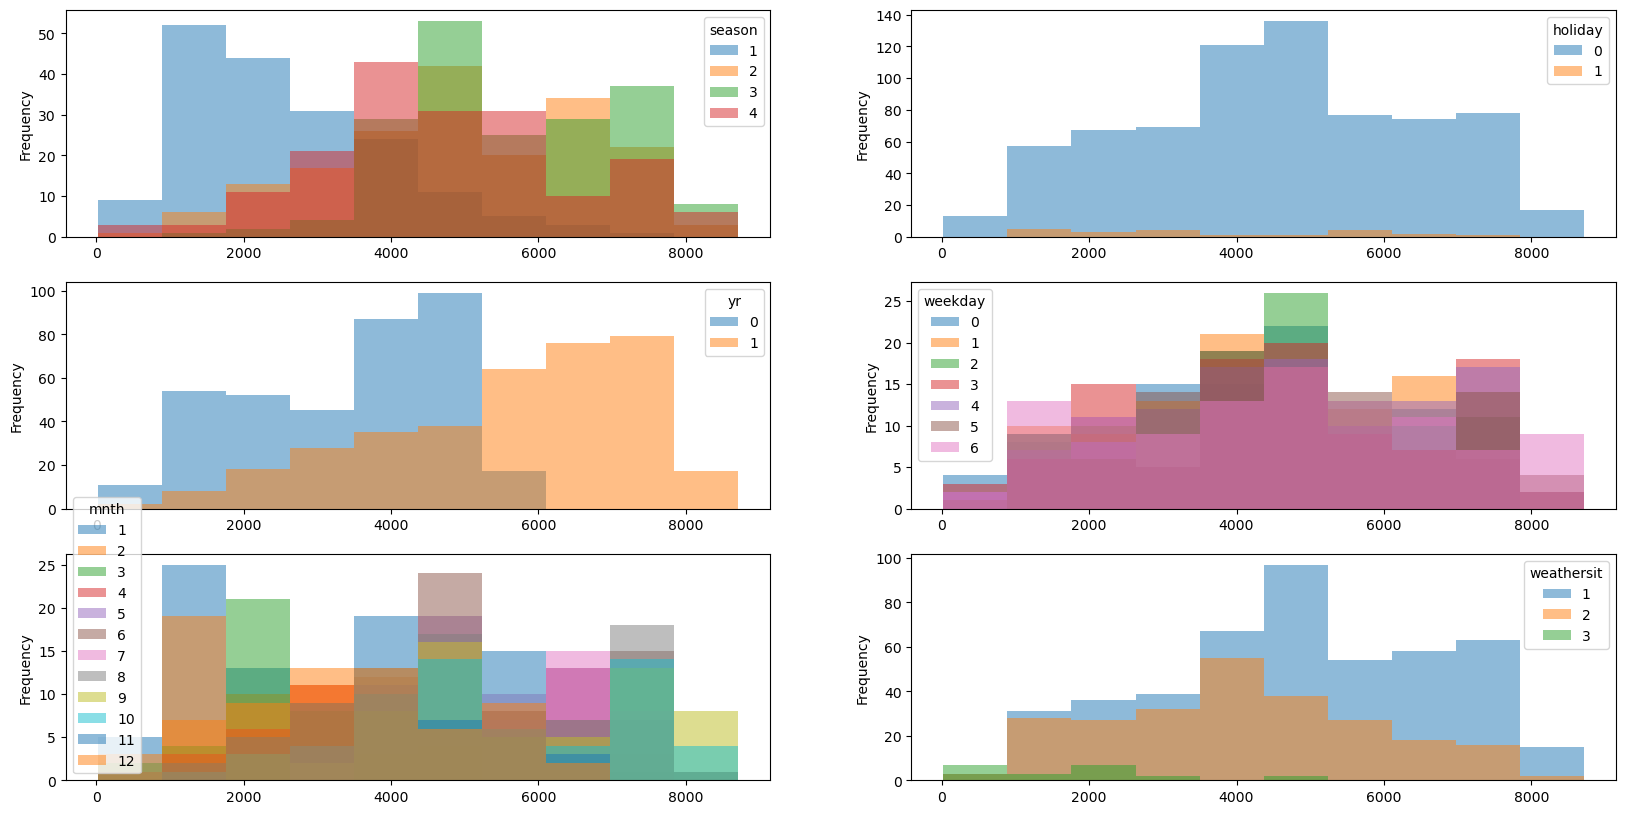

In [7]:
fig,axes = plt.subplots(3,2,figsize = (20,10))
i,j = 0,0
for c in cc:
    df[[c,'cnt']].reset_index().pivot_table(index = 'instant', columns = c, values = 'cnt').plot(kind = 'hist', ax = axes[i,j], alpha = 0.5)
    if i==2:
        i = 0
        j = 1
    else:
        i+=1

## Corelation with numerical variables

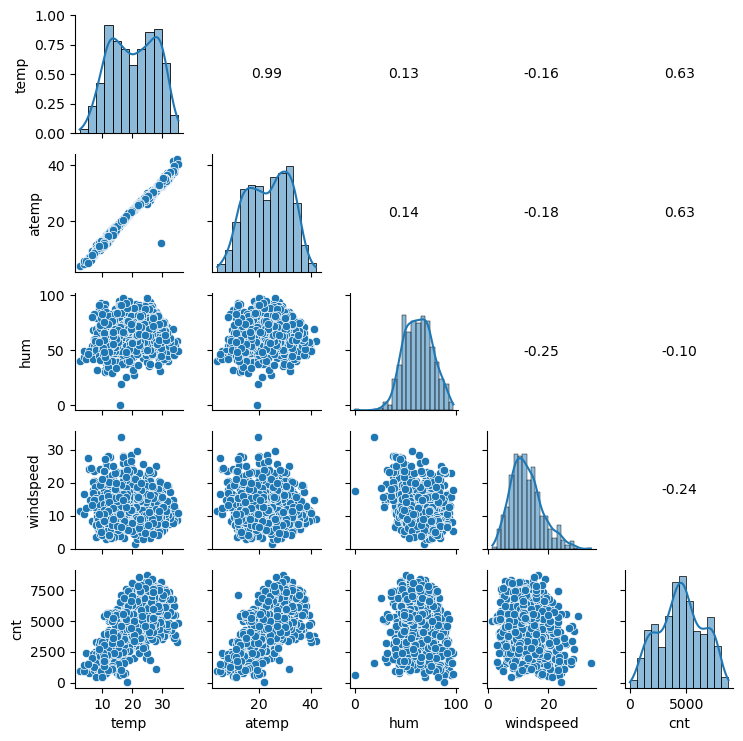

In [8]:
def correlation_coefficient(x, y, **kwargs):
    corr = np.corrcoef(x, y)[0, 1]
    ax = plt.gca()
    ax.set_axis_off()
    ax.annotate(f"{corr:.2f}", xy=(0.5, 0.5), xycoords="axes fraction", ha="center", va="center", fontsize=10)


g = sns.PairGrid(df[['temp', 'atemp', 'hum', 'windspeed','cnt']],height=1.5)
g.map_lower(sns.scatterplot)
g.map_upper(correlation_coefficient)
g.map_diag(sns.histplot, kde=True)  # Optional: histograms on the diagonal

plt.show()

## takeaways 
1. temperature and real feel metric are highlt correlated and can use only one where real feel looks better approximate
2. humidity and windspeed does not look corelated with 'cnt' variable but still keeping them in first model - look to remove these later

## defining and retainig catagorical variables

In [9]:
cat_vars = ['season','yr','mnth','holiday','weekday','workingday','weathersit']

In [10]:
remove_cols = ['dteday','temp']

In [11]:
df1 = df.loc[:,[col for col in df.columns if col not in remove_cols] ]

In [12]:
## checking variables with 2 and more than 2 unique values
only_2_unique = []
cat_process_vars = []
for var in cat_vars:
    print (var ,'-', (len(df[var].unique())))
    if (len(df[var].unique())) == 2:
        only_2_unique.append(var)
    else:
        cat_process_vars.append(var)

season - 4
yr - 2
mnth - 12
holiday - 2
weekday - 7
workingday - 2
weathersit - 3


### For features with only 2 unique values -
- converting into categorical varaibes only

### For features with more than 2 unique values -
- converting into categorical variabeles and creating dummies

In [13]:
processed_df = pd.concat([df1[only_2_unique].astype(str),
            pd.get_dummies(df1[cat_process_vars].astype(str), drop_first = True).astype(int),
            df1.loc[:,[col for col in df1.columns if col not in cat_vars]]]
            , axis=1)

## importing libraries for training

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error, r2_score 

In [15]:
train_df, test_df = train_test_split(processed_df, test_size= 0.3, random_state = 3)

In [16]:
X_train = train_df.drop(['casual','registered','cnt'], axis=1)
y_train_reg = train_df.registered
y_train_casual = train_df.casual

X_test = test_df.drop(['casual','registered','cnt'], axis=1)
y_test_reg = test_df.registered
y_test_casual = test_df.casual

## scaling all

In [17]:
x_scaler = StandardScaler()
X_train[['atemp', 'hum', 'windspeed']] = x_scaler.fit_transform(X_train[['atemp', 'hum', 'windspeed']])
X_test[['atemp', 'hum', 'windspeed']] = x_scaler.transform(X_test[['atemp', 'hum', 'windspeed']])

y_reg_scaler = StandardScaler()
y_reg_train_scaled = y_reg_scaler.fit_transform(y_train_reg.values.reshape(-1,1))
y_reg_test_scaled = y_reg_scaler.transform(y_test_reg.values.reshape(-1,1))

y_casual_scaler = StandardScaler()
y_casual_train_scaled = y_casual_scaler.fit_transform(y_train_casual.values.reshape(-1,1))
y_casual_test_scaled = y_casual_scaler.transform(y_test_casual.values.reshape(-1,1))

## training 2 models

In [18]:
lm_reg = LinearRegression()
lm_reg.fit(X_train, y_reg_train_scaled)

LinearRegression()

In [19]:
lm_casual = LinearRegression()
lm_casual.fit(X_train, y_casual_train_scaled)

LinearRegression()

## feature coefficients

<Axes: ylabel='Frequency'>

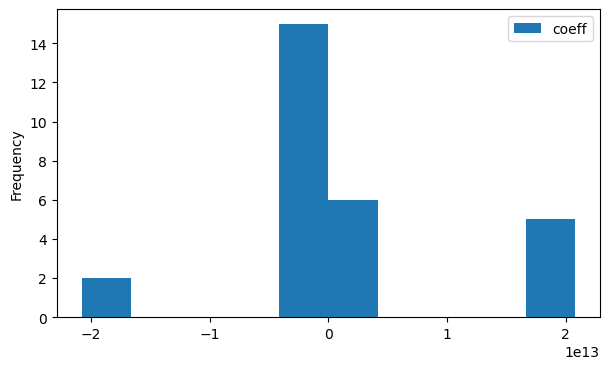

In [110]:
pd.DataFrame(lm_reg.coef_, columns = lm_reg.feature_names_in_, index = ['coeff']).T.sort_values(by = 'coeff').plot(kind = 'hist', figsize = (7,4))

## Predicting on test data

## added an adjustment in predictions -
1. Since number of bookings under each category cannot be below 0
2. Replaced less than 0 predictions with 0

In [34]:
def get_result_on_test_set(X_test, y_reg_scaler,reg_model,casual_model,test_df,y_reg_test_scaled,y_casual_test_scaled):
    registed_test_df = pd.concat([pd.DataFrame(y_reg_scaler.inverse_transform(reg_model.predict(X_test)),columns = ['pred_registered'], index = test_df.index),
                              pd.DataFrame(y_reg_scaler.inverse_transform(y_reg_test_scaled), columns = ['act_registered'], index = test_df.index ) ]
                             , axis=1).round()
    casual_test_df = pd.concat([pd.DataFrame(y_casual_scaler.inverse_transform(casual_model.predict(X_test)),columns = ['pred_casual'], index = test_df.index),
                            pd.DataFrame(y_casual_scaler.inverse_transform(y_casual_test_scaled), columns = ['act_casual'], index = test_df.index ) ]
                           , axis=1).round()
    
    result_df =  pd.concat([registed_test_df, casual_test_df], axis=1)
    result_df.loc[result_df.pred_casual < 0, 'pred_casual'] = 0
    result_df.loc[result_df.pred_registered < 0, 'pred_registered'] = 0

    result_df['act_cnt'] = result_df[['act_registered','act_casual']].sum(axis=1)
    result_df['pred_cnt'] = result_df[['pred_registered','pred_casual']].sum(axis=1)

    return result_df

In [35]:
result_df = get_result_on_test_set(X_test, y_reg_scaler,lm_reg,lm_casual,test_df,y_reg_test_scaled,y_casual_test_scaled)

<Axes: xlabel='act_cnt', ylabel='pred_cnt'>

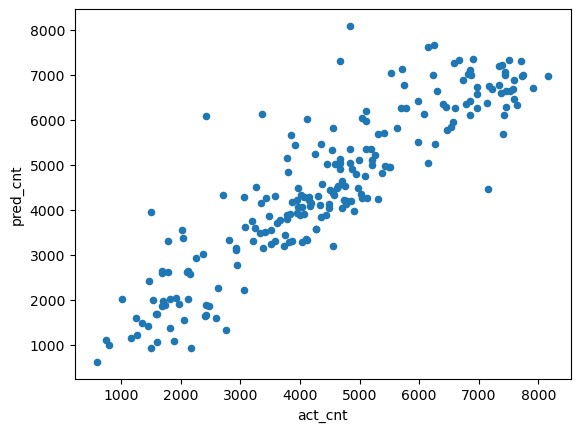

In [36]:
result_df[['act_cnt','pred_cnt']].plot(x = 'act_cnt', y = 'pred_cnt', kind = 'scatter')

In [37]:
mean_squared_error(result_df.act_cnt, result_df.pred_cnt)

704607.091324201

In [38]:
r2_score(result_df.act_cnt, result_df.pred_cnt)

0.7964062032318886

## First Basic model results -
1. Trained first base model including all features with sklearn
2. Giving R2 score of 0.79
3. Coeff values are noisy and contains too high values,making model unreliable


## checking with stats model

In [39]:
import statsmodels.api as sm

In [40]:
remove_cols = ['dteday']

In [41]:
df1 = df.loc[:,[col for col in df.columns if col not in remove_cols] ]

In [44]:
## checking variables with 2 and more than 2 unique values
only_2_unique = []
cat_process_vars = []
for var in cat_vars:
    print (var ,'-', (len(df1[var].unique())))
    if (len(df1[var].unique())) == 2:
        only_2_unique.append(var)
    else:
        cat_process_vars.append(var)

season - 4
yr - 2
mnth - 12
holiday - 2
weekday - 7
workingday - 2
weathersit - 3


In [45]:
processed_df = pd.concat([df1[only_2_unique].astype(str),
            pd.get_dummies(df1[cat_process_vars].astype(str), drop_first = True).astype(int),
            df1.loc[:,[col for col in df1.columns if col not in cat_vars]]]
            , axis=1)

In [47]:
train_df, test_df = train_test_split(processed_df, test_size= 0.3, random_state = 3)

In [48]:
X_train = train_df.drop(['casual','registered','cnt'], axis=1)
y_train_reg = train_df.registered
y_train_casual = train_df.casual

X_test = test_df.drop(['casual','registered','cnt'], axis=1)
y_test_reg = test_df.registered
y_test_casual = test_df.casual

## scaling all

In [49]:
x_scaler = StandardScaler()
X_train[['temp', 'atemp', 'hum', 'windspeed']] = x_scaler.fit_transform(X_train[['temp', 'atemp', 'hum', 'windspeed']])
X_test[['temp', 'atemp', 'hum', 'windspeed']] = x_scaler.transform(X_test[['temp', 'atemp', 'hum', 'windspeed']])

y_reg_scaler = StandardScaler()
y_reg_train_scaled = y_reg_scaler.fit_transform(y_train_reg.values.reshape(-1,1))
y_reg_test_scaled = y_reg_scaler.transform(y_test_reg.values.reshape(-1,1))

y_casual_scaler = StandardScaler()
y_casual_train_scaled = y_casual_scaler.fit_transform(y_train_casual.values.reshape(-1,1))
y_casual_test_scaled = y_casual_scaler.transform(y_test_casual.values.reshape(-1,1))

In [50]:
X_train_sm = X_train.copy()

X_train_sm[['yr','holiday','workingday']] = X_train_sm[['yr','holiday','workingday']].astype(int)
X_train_sm = sm.add_constant(X_train_sm)

In [51]:
# Fit the model
model = sm.OLS(y_reg_train_scaled, X_train_sm).fit()

In [52]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     103.6
Date:                Mon, 28 Oct 2024   Prob (F-statistic):          3.16e-184
Time:                        21:40:12   Log-Likelihood:                -227.16
No. Observations:                 511   AIC:                             512.3
Df Residuals:                     482   BIC:                             635.2
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -1.5766      0.098    -16.083      0.000      -1.769      -1.384
yr               1.0833      0.036     30.407      0.000       1.013       1.153
holiday          0.1089      0.092      1.187      0.236      -0.071       0.289
workingday       0.5701      0.041     13.830      0.000       0.489       0.651
season_2         0.5119      0.113      4.549      0.000       0.291       0.733
season_3         0.5014      0.130      3.868      0.000       0.247       0.756
season_4         0.9592      0.109      8.768      0.000       0.744       1.174
mnth_10          0.1084      0.144      0.754      0.451      -0.174       0.391
mnth_11         -0.1513      0.138     -1.093      0.275      -0.423       0.121
mnth_12         -0.0616      0.110     -0.558      0.577      -0.278       0.155
mnth_2           0.1191      0.088      1.349      0.178      -0.054       0.293
mnth_3           0.2005      0.099      2.017      0.044       0.005       0.396
mnth_4           0.0828      0.156      0.529      0.597      -0.225       0.390
mnth_5           0.1945      0.169      1.153      0.249      -0.137       0.526
mnth_6           0.2099      0.177      1.188      0.235      -0.137       0.557
mnth_7           0.0236      0.197      0.120      0.904      -0.363       0.410
mnth_8           0.2204      0.188      1.173      0.241      -0.149       0.590
mnth_9           0.4562      0.164      2.773      0.006       0.133       0.779
weekday_1       -0.0304      0.043     -0.709      0.479      -0.115       0.054
weekday_2        0.1485      0.047      3.150      0.002       0.056       0.241
weekday_3        0.2197      0.048      4.573      0.000       0.125       0.314
weekday_4        0.2195      0.049      4.512      0.000       0.124       0.315
weekday_5        0.1218      0.047      2.613      0.009       0.030       0.213
weekday_6        0.2155      0.064      3.368      0.001       0.090       0.341
weathersit_2    -0.2200      0.047     -4.659      0.000      -0.313      -0.127
weathersit_3    -1.1882      0.126     -9.393      0.000      -1.437      -0.940
temp            -0.2946      0.250     -1.177      0.240      -0.786       0.197
atemp            0.6068      0.240      2.532      0.012       0.136       1.078
hum             -0.1085      0.025     -4.332      0.000      -0.158      -0.059
windspeed       -0.0835      0.020     -4.141      0.000      -0.123      -0.044
==============================================================================
Omnibus:                      165.267   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              627.481
Skew:                          -1.441   Prob(JB):                    5.55e-137
Kurtosis:                       7.600   Cond. No.                     1.07e+15
===============

In [53]:
model_casual = sm.OLS(y_casual_train_scaled, X_train_sm).fit()

In [54]:
model_casual.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.754
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     52.71
Date:                Mon, 28 Oct 2024   Prob (F-statistic):          1.11e-127
Time:                        21:40:58   Log-Likelihood:                -366.96
No. Observations:                 511   AIC:                             791.9
Df Residuals:                     482   BIC:                             914.8
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.2314      0.129      1.796      0.073      -0.022       0.485
yr               0.4344      0.047      9.275      0.000       0.342       0.526
holiday         -0.1394      0.121     -1.156      0.248      -0.376       0.098
workingday      -0.8883      0.054    -16.391      0.000      -0.995      -0.782
season_2         0.3980      0.148      2.690      0.007       0.107       0.689
season_3         0.1063      0.170      0.624      0.533      -0.229       0.441
season_4        -0.0263      0.144     -0.183      0.855      -0.309       0.256
mnth_10          0.5748      0.189      3.040      0.002       0.203       0.946
mnth_11          0.3072      0.182      1.689      0.092      -0.050       0.665
mnth_12          0.0755      0.145      0.520      0.603      -0.210       0.361
mnth_2          -0.0735      0.116     -0.633      0.527      -0.302       0.155
mnth_3           0.3909      0.131      2.991      0.003       0.134       0.648
mnth_4           0.1501      0.206      0.730      0.466      -0.254       0.554
mnth_5           0.3078      0.222      1.389      0.166      -0.128       0.743
mnth_6          -0.0149      0.232     -0.064      0.949      -0.471       0.442
mnth_7           0.0791      0.259      0.306      0.760      -0.429       0.587
mnth_8           0.1221      0.247      0.495      0.621      -0.363       0.607
mnth_9           0.3849      0.216      1.780      0.076      -0.040       0.810
weekday_1       -0.2130      0.056     -3.776      0.000      -0.324      -0.102
weekday_2       -0.2467      0.062     -3.982      0.000      -0.368      -0.125
weekday_3       -0.2952      0.063     -4.675      0.000      -0.419      -0.171
weekday_4       -0.2486      0.064     -3.887      0.000      -0.374      -0.123
weekday_5       -0.0241      0.061     -0.394      0.694      -0.144       0.096
weekday_6        0.1973      0.084      2.345      0.019       0.032       0.363
weathersit_2    -0.1469      0.062     -2.367      0.018      -0.269      -0.025
weathersit_3    -0.4124      0.166     -2.480      0.013      -0.739      -0.086
temp             0.4137      0.329      1.258      0.209      -0.233       1.060
atemp            0.0483      0.315      0.153      0.878      -0.571       0.667
hum             -0.1036      0.033     -3.146      0.002      -0.168      -0.039
windspeed       -0.1158      0.027     -4.367      0.000      -0.168      -0.064
==============================================================================
Omnibus:                       53.652   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              111.901
Skew:                           0.600   Prob(JB):                     5.02e-25
Kurtosis:                       4.954   Cond. No.                     1.07e+15
===============

<Axes: >

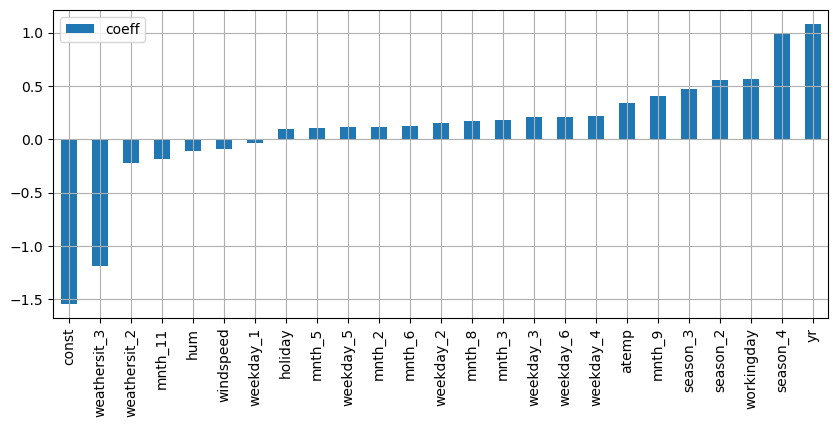

In [116]:
pd.DataFrame(model.params, columns = ['coeff']).round(4).sort_values(by = 'coeff').plot(kind = 'bar', figsize = (10,4), grid = True)

In [56]:
X_test_sm = X_test.copy()

X_test_sm[['yr','holiday','workingday']] = X_test_sm[['yr','holiday','workingday']].astype(int)
X_test_sm = sm.add_constant(X_test_sm)


In [57]:
result_df1 = pd.concat([pd.DataFrame(y_reg_scaler.inverse_transform(model.predict(X_test_sm).values.reshape(-1,1)), index = test_df.index, columns = ['reg_pred']).round(),
           pd.DataFrame(y_casual_scaler.inverse_transform(model_casual.predict(X_test_sm).values.reshape(-1,1)), index = test_df.index, columns = ['casual_pred']).round(),
           pd.DataFrame(y_reg_scaler.inverse_transform(y_reg_test_scaled), columns = ['act_registered'], index = test_df.index ),
           pd.DataFrame(y_casual_scaler.inverse_transform(y_casual_test_scaled), columns = ['act_casual'], index = test_df.index )], axis=1)

In [58]:
result_df1['act_cnt'] = result_df1[['act_registered','act_casual']].sum(axis=1)
result_df1['pred_cnt'] = result_df1[['reg_pred','casual_pred']].sum(axis=1)

In [59]:
r2_score(result_df1.act_cnt, result_df1.pred_cnt)

0.8183945180978157

## Takeaways -
1. Few months features have high P value and can be removed
2. Starting with removing mnth_12,mnth_10, mnth_7 and mnth_4

In next iteration - 
1. removed temp too, because of high P and similar impact as atemp

## removing weekday related features, got it by experimentation that this is adding noise in the weights

In [144]:
X_train_sm = X_train.copy()

X_train_sm[['yr','holiday','workingday']] = X_train_sm[['yr','holiday','workingday']].astype(int)
X_train_sm = sm.add_constant(X_train_sm)
X_train_sm = X_train_sm.loc[:,~X_train_sm.columns.str.contains('mnth_10|mnth_12|mnth_4|mnth_7')]

In [145]:
X_train_sm.drop('temp', axis=1, inplace = True)

weekday - 0 and 6 are saturday/sunday - combining these 2 together and rest all

In [146]:
# X_train_sm['weekday_weekend'] = X_train_sm[['weekday_0', 'weekday_6']].sum(axis=1)
# X_train_sm['weekday_weekday'] = X_train_sm[['weekday_1', 'weekday_2','weekday_3', 'weekday_4','weekday_5']].sum(axis=1)

# X_train_sm.drop(['weekday_0','weekday_1', 'weekday_2','weekday_3', 'weekday_4','weekday_5','weekday_6'], axis=1, inplace = True)

In [147]:
# Fit the model
model = sm.OLS(y_reg_train_scaled, X_train_sm).fit()

In [148]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     125.8
Date:                Mon, 28 Oct 2024   Prob (F-statistic):          3.17e-188
Time:                        22:49:37   Log-Likelihood:                -230.07
No. Observations:                 511   AIC:                             508.1
Df Residuals:                     487   BIC:                             609.8
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -1.5440      0.078    -19.857      0.000      -1.697      -1.391
yr               1.0832      0.035     30.714      0.000       1.014       1.153
holiday          0.0938      0.090      1.038      0.300      -0.084       0.271
workingday       0.5701      0.041     13.859      0.000       0.489       0.651
season_2         0.5548      0.075      7.435      0.000       0.408       0.701
season_3         0.4723      0.102      4.645      0.000       0.273       0.672
season_4         0.9907      0.070     14.140      0.000       0.853       1.128
mnth_11         -0.1820      0.074     -2.448      0.015      -0.328      -0.036
mnth_2           0.1204      0.081      1.488      0.137      -0.039       0.279
mnth_3           0.1782      0.072      2.460      0.014       0.036       0.320
mnth_5           0.1094      0.086      1.278      0.202      -0.059       0.277
mnth_6           0.1224      0.077      1.584      0.114      -0.029       0.274
mnth_8           0.1685      0.081      2.073      0.039       0.009       0.328
mnth_9           0.4112      0.076      5.378      0.000       0.261       0.561
weekday_1       -0.0296      0.043     -0.690      0.490      -0.114       0.055
weekday_2        0.1504      0.047      3.194      0.001       0.058       0.243
weekday_3        0.2084      0.047      4.389      0.000       0.115       0.302
weekday_4        0.2167      0.048      4.493      0.000       0.122       0.311
weekday_5        0.1181      0.046      2.545      0.011       0.027       0.209
weekday_6        0.2127      0.064      3.342      0.001       0.088       0.338
weathersit_2    -0.2215      0.047     -4.720      0.000      -0.314      -0.129
weathersit_3    -1.1921      0.125     -9.513      0.000      -1.438      -0.946
atemp            0.3444      0.034      9.996      0.000       0.277       0.412
hum             -0.1088      0.025     -4.430      0.000      -0.157      -0.061
windspeed       -0.0880      0.019     -4.596      0.000      -0.126      -0.050
==============================================================================
Omnibus:                      151.335   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              510.092
Skew:                          -1.356   Prob(JB):                    1.72e-111
Kurtosis:                       7.075   Cond. No.                     1.06e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.04e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [149]:
model_casual = sm.OLS(y_casual_train_scaled, X_train_sm).fit()

In [150]:
model_casual.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     61.17
Date:                Mon, 28 Oct 2024   Prob (F-statistic):          1.32e-127
Time:                        22:49:37   Log-Likelihood:                -378.08
No. Observations:                 511   AIC:                             804.2
Df Residuals:                     487   BIC:                             905.8
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.2952      0.104      2.842      0.005       0.091       0.499
yr               0.4252      0.047      9.024      0.000       0.333       0.518
holiday         -0.0997      0.121     -0.825      0.410      -0.337       0.138
workingday      -0.8873      0.055    -16.145      0.000      -0.995      -0.779
season_2         0.4394      0.100      4.407      0.000       0.244       0.635
season_3         0.1303      0.136      0.959      0.338      -0.137       0.397
season_4         0.2669      0.094      2.852      0.005       0.083       0.451
mnth_11         -0.0445      0.099     -0.448      0.654      -0.240       0.151
mnth_2          -0.1111      0.108     -1.028      0.304      -0.324       0.101
mnth_3           0.3096      0.097      3.199      0.001       0.119       0.500
mnth_5           0.1644      0.114      1.438      0.151      -0.060       0.389
mnth_6          -0.1473      0.103     -1.427      0.154      -0.350       0.056
mnth_8           0.0030      0.109      0.028      0.978      -0.210       0.216
mnth_9           0.2102      0.102      2.057      0.040       0.009       0.411
weekday_1       -0.2110      0.057     -3.687      0.000      -0.323      -0.099
weekday_2       -0.2360      0.063     -3.752      0.000      -0.360      -0.112
weekday_3       -0.2865      0.063     -4.515      0.000      -0.411      -0.162
weekday_4       -0.2420      0.064     -3.756      0.000      -0.369      -0.115
weekday_5       -0.0115      0.062     -0.185      0.853      -0.133       0.110
weekday_6        0.2174      0.085      2.557      0.011       0.050       0.384
weathersit_2    -0.1375      0.063     -2.193      0.029      -0.261      -0.014
weathersit_3    -0.3535      0.167     -2.112      0.035      -0.682      -0.025
atemp            0.4988      0.046     10.837      0.000       0.408       0.589
hum             -0.1073      0.033     -3.269      0.001      -0.172      -0.043
windspeed       -0.1013      0.026     -3.961      0.000      -0.152      -0.051
==============================================================================
Omnibus:                       48.946   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               98.332
Skew:                           0.564   Prob(JB):                     4.44e-22
Kurtosis:                       4.830   Cond. No.                     1.06e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.04e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [151]:
X_test_sm = X_test.copy()

X_test_sm[['yr','holiday','workingday']] = X_test_sm[['yr','holiday','workingday']].astype(int)
X_test_sm = sm.add_constant(X_test_sm)
X_test_sm = X_test_sm.loc[:,~X_test_sm.columns.str.contains('mnth_10|mnth_12|mnth_4|mnth_7')]

X_test_sm.drop('temp', axis=1, inplace = True)

In [152]:
result_df1 = pd.concat([pd.DataFrame(y_reg_scaler.inverse_transform(model.predict(X_test_sm).values.reshape(-1,1)), index = test_df.index, columns = ['reg_pred']).round(),
           pd.DataFrame(y_casual_scaler.inverse_transform(model_casual.predict(X_test_sm).values.reshape(-1,1)), index = test_df.index, columns = ['casual_pred']).round(),
           pd.DataFrame(y_reg_scaler.inverse_transform(y_reg_test_scaled), columns = ['act_registered'], index = test_df.index ),
           pd.DataFrame(y_casual_scaler.inverse_transform(y_casual_test_scaled), columns = ['act_casual'], index = test_df.index )], axis=1)

In [ ]:
result_df1.loc[result_df1.reg_pred < 0,'reg_pred'] = 0
result_df1.loc[result_df1.casual_pred < 0, 'casual_pred'] = 0

In [155]:
result_df1['act_cnt'] = result_df1[['act_registered','act_casual']].sum(axis=1)
result_df1['pred_cnt'] = result_df1[['reg_pred','casual_pred']].sum(axis=1)

In [156]:
r2_score(result_df1.act_cnt, result_df1.pred_cnt)

0.8179928797375206

In [157]:
result_df1['errors'] = result_df1.act_cnt - result_df.pred_cnt

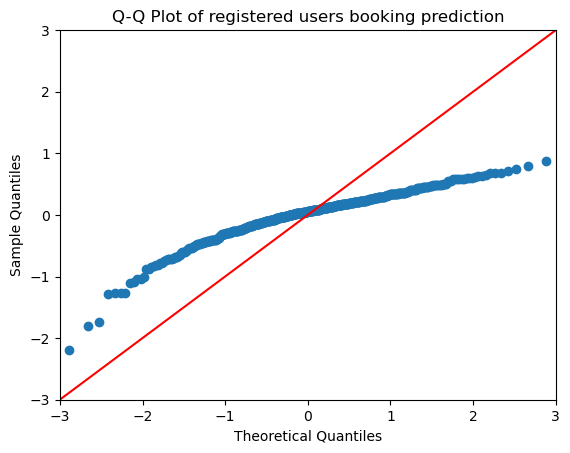

In [159]:
sm.qqplot(model.resid, line='45')  # 'line=45' adds a 45-degree reference line
plt.title("Q-Q Plot of registered users booking prediction")
plt.show()

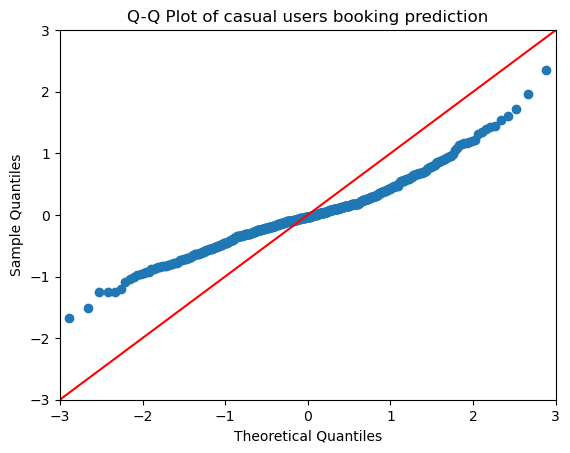

In [160]:
sm.qqplot(model_casual.resid, line='45')  # 'line=45' adds a 45-degree reference line
plt.title("Q-Q Plot of casual users booking prediction")
plt.show()

In [102]:
pd.set_option('display.float_format', '{:.4f}'.format)

<Axes: >

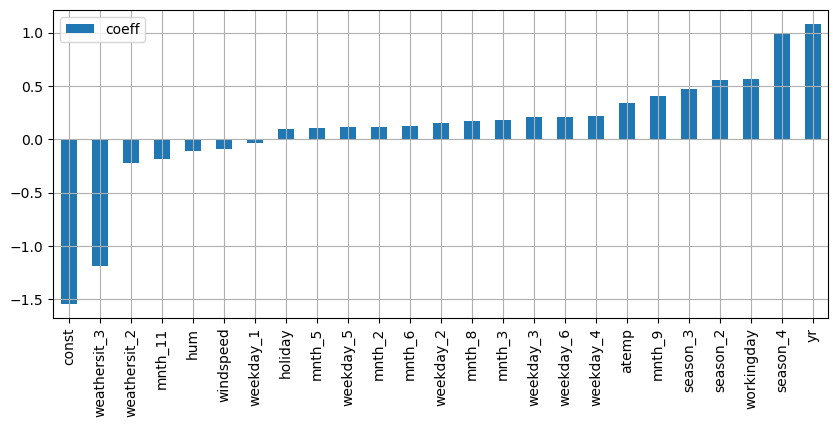

In [161]:
pd.DataFrame(model.params, columns = ['coeff']).round(4).sort_values(by = 'coeff').plot(kind = 'bar', figsize = (10,4), grid = True)

## Actionables/Outcomes from the model

1. In bad weather, bookings drop significantly, there is nothing we can do about it but plan accordingly
2. Spring season negatively impact the booking, can plan for alternate routes/localities which are uneffected in the spring season
3. There are certain months November, December and July (probably by weather) when bookings are low
4. Humidity and windspeed negatively impacts the booking
5. On other side, higher temperature promotes bookings
6. And bookings are high on working day and year-on-year growth on top of it

# final R2 of the used model -

In [104]:
r2_score(result_df1.act_cnt, result_df1.pred_cnt)

0.8179928797375206